In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import skgstat as skg
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [2]:
# DISC\\Python
cwd = "..\\"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"

In [15]:
# Constant! 
g = 4.66

In [3]:
# Find the coordinate based on the name of the site in our .csv file
df_Site = pd.read_csv(cwd + "//Site.csv")
df_Site.head()

,Number,Site,Serial Number (FLOX),Country,Location,Latitude,Longitude,Priority,Plant functional type (PFT),Reference network,Number of components,Reduce ROI size (600 x 600 m),Move ROI,Comments,PRISMA Availability (900m Buffer ROI Check),PRISMA Earliest Date,PRISMA Latest Date (Before 2024-06-26),Tomi,S2 Cloud
0,1,ATGE,NaN,NaN,NaN,52.466778,12.959778,NaN,NaN,HYPERNET,NaN,NaN,NaN,NaN,2,2022-05-06,2023-08-14,Y,NaN
1,2,ATLAS-Mohammed V,NaN,Morocco,ATLAS-Mohammed V,33.406152,-5.103319,Low,NaN,NaN,NaN,Yes,Yes,"mixed pixel, complex topography",2,2023-11-23,2023-11-23,NaN,NaN
2,3,AU-MIEMING,JB-042-GW,Austria,Austria,47.316700,10.970300,NaN,NaN,FLOX,NaN,No,No,topography?,0,NaN,NaN,Duplicate,NaN
3,4,BASP,NaN,NaN,NaN,39.049139,-2.075917,NaN,NaN,HYPERNET,NaN,NaN,NaN,NaN,27,2022-05-09,2024-06-18,Y,NaN
4,5,BE-BRASCHAAT,JB-021-SW,Belgium,Brasschaat,51.307600,4.519900,NaN,NaN,FLOX,NaN,No,No,Check the site with Sentinal 3,7,2020-09-12,2022-06-01,NaN,NaN


In [17]:
def get_Coordinates_from_Rio(img):
    list_Coordinates = []
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            temp_x, temp_y = img.xy(x, y)
            temp_list = [temp_x, temp_y]
            list_Coordinates.append(temp_list)
    list_Coordinates = np.array(list_Coordinates)
    return(list_Coordinates)

In [18]:
def my_Variogram(site_Name):
    img_30 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 30m.tif")
    band_30 = img_30.read(1)
    img_100 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 100m.tif")
    band_100 = img_100.read(1)
    img_300 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 300m.tif")
    band_300 = img_300.read(1)
    img_900 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 900m.tif")
    band_900 = img_900.read(1)
    img_1200 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 1200m.tif")
    band_1200 = img_1200.read(1)
    band_30_reshape = band_30.reshape(-1)
    band_100_reshape = band_100.reshape(-1)
    band_300_reshape = band_300.reshape(-1)
    band_900_reshape = band_900.reshape(-1)
    band_1200_reshape = band_1200.reshape(-1)
    arr_Coordinates_30 = get_Coordinates_from_Rio(img_30)
    arr_Coordinates_100 = get_Coordinates_from_Rio(img_100)
    arr_Coordinates_300 = get_Coordinates_from_Rio(img_300)
    arr_Coordinates_900 = get_Coordinates_from_Rio(img_900)
    arr_Coordinates_1200 = get_Coordinates_from_Rio(img_1200)
    diagonal_30 = 30 * (2 ** 0.5) / 2
    bin_30 = np.arange(10,diagonal_30,10)     
    diagonal_100 = 100 * (2 ** 0.5) / 2
    bin_100 = np.arange(10,diagonal_100,10)     
    diagonal_300 = 300 * (2 ** 0.5) / 2
    bin_300 = np.arange(10,diagonal_300,10)     
    diagonal_900 = 900 * (2 ** 0.5) / 2
    bin_900 = np.arange(10,diagonal_900,10)     
    diagonal_1200 = 1200 * (2 ** 0.5) / 2
    bin_1200 = np.arange(10,diagonal_1200,10)
    V_30 = skg.Variogram(arr_Coordinates_30, band_30_reshape, use_nugget=True, bin_func=bin_30, maxlag = bin_30[-1])
    V_100 = skg.Variogram(arr_Coordinates_100, band_100_reshape, use_nugget=True, bin_func=bin_100, maxlag = bin_100[-1])
    V_300 = skg.Variogram(arr_Coordinates_300, band_300_reshape, use_nugget=True, bin_func=bin_300, maxlag = bin_300[-1])
    V_900 = skg.Variogram(arr_Coordinates_900, band_900_reshape, use_nugget=True, bin_func=bin_900, maxlag = bin_900[-1])
    V_1200 = skg.Variogram(arr_Coordinates_1200, band_1200_reshape, use_nugget=True, bin_func=bin_1200, maxlag = bin_1200[-1])
    range_30 = V_30.parameters[0]
    sill_30 = V_30.parameters[1] + V_30.parameters[2]
    nugget_30 = V_30.parameters[2]
    range_100 = V_100.parameters[0]
    sill_100 = V_100.parameters[1] + V_100.parameters[2]
    nugget_100 = V_100.parameters[2]
    range_300 = V_300.parameters[0]
    sill_300 = V_300.parameters[1] + V_300.parameters[2]
    nugget_300 = V_300.parameters[2]
    range_900 = V_900.parameters[0]
    sill_900 = V_900.parameters[1] + V_900.parameters[2]
    nugget_900 = V_900.parameters[2]
    range_1200 = V_1200.parameters[0]
    sill_1200 = V_1200.parameters[1] + V_1200.parameters[2]
    nugget_1200 = V_1200.parameters[2]
    # STD
    STD_30 = np.std(band_30)
    STD_100 = np.std(band_100)
    STD_300 = np.std(band_300)
    STD_900 = np.std(band_900)
    STD_1200 = np.std(band_1200)
    # CV
    CV_30 = np.std(band_30) / np.mean(band_30)
    CV_100 = np.std(band_100) / np.mean(band_100)
    CV_300 = np.std(band_300) / np.mean(band_300)
    CV_900 = np.std(band_900) / np.mean(band_900)
    CV_1200 = np.std(band_1200) / np.mean(band_1200)
    # Rcv
    Rcv_30_100 = (CV_100 - CV_30) / CV_30
    Rcv_30_300 = (CV_300 - CV_30) / CV_30
    Rcv_100_300 = (CV_300 - CV_100) / CV_100
    Rcv_300_900 = (CV_900 - CV_300) / CV_300
    Rcv_300_1200 = (CV_1200 - CV_300) / CV_300
    # RAW
    RAW_30_100 = (abs(2 * Rcv_30_100)) ** (-1)
    RAW_30_300 = (abs(2 * Rcv_30_300)) ** (-1)
    RAW_100_300 = (abs(2 * Rcv_100_300)) ** (-1)
    RAW_300_900 = (abs(2 * Rcv_300_900)) ** (-1)
    RAW_300_1200 = (abs(2 * Rcv_300_1200)) ** (-1)
    # Rse
    Rse_30_100 = math.exp(-((g / range_30) ** 2 + (g / range_100) ** 2) ** (1/2))
    Rse_30_300 = math.exp(-((g / range_30) ** 2 + (g / range_300) ** 2) ** (1/2))
    Rse_100_300 = math.exp(-((g / range_100) ** 2 + (g / range_300) ** 2) ** (1/2))
    Rse_300_900 = math.exp(-((g / range_300) ** 2 + (g / range_900) ** 2) ** (1/2))
    Rse_300_1200 = math.exp(-((g / range_300) ** 2 + (g / range_1200) ** 2) ** (1/2))
    # Rst
    # Get the index of the range in the bin
    for i in range(len(V_30.bins)):
        if range_30 >= V_30.bins[i] and range_30 <= V_30.bins[i+1]:
            index_30 = i + 1
    estimator_Range_30 = V_30.experimental[index_30]
    for i in range(len(V_100.bins)):
        if range_100 >= V_100.bins[i] and range_100 <= V_100.bins[i+1]:
            index_100 = i + 1
    estimator_Range_100 = V_100.experimental[index_100]
    for i in range(len(V_300.bins)):
        if range_300 >= V_300.bins[i] and range_300 <= V_300.bins[i+1]:
            index_300 = i + 1
    estimator_Range_300 = V_300.experimental[index_300]
    for i in range(len(V_900.bins)):
        if range_900 >= V_900.bins[i] and range_900 <= V_900.bins[i+1]:
            index_900 = i + 1
    estimator_Range_900 = V_900.experimental[index_900]
    for i in range(len(V_1200.bins)):
        if range_1200 >= V_1200.bins[i] and range_1200 <= V_1200.bins[i+1]:
            index_1200 = i + 1
    estimator_Range_1200 = V_1200.experimental[index_1200]
    ST_30 = (estimator_Range_30 - nugget_30) / estimator_Range_30
    ST_100 = (estimator_Range_100 - nugget_100) / estimator_Range_100
    ST_300 = (estimator_Range_300 - nugget_300) / estimator_Range_300
    ST_900 = (estimator_Range_900 - nugget_900) / estimator_Range_900
    ST_1200 = (estimator_Range_1200 - nugget_1200) / estimator_Range_1200
    Rst_30_100 = (ST_100 - ST_30) / ST_30
    Rst_30_300 = (ST_300 - ST_30) / ST_30
    Rst_100_300 = (ST_300 - ST_100) / ST_100
    Rst_300_900 = (ST_900 - ST_300) / ST_300
    Rst_300_1200 = (ST_1200 - ST_300) / ST_300
    # Rsv
    def f_30_SV(x):
        return (V_30.fitted_model(x) - nugget_30) / sill_30
    def f_100_SV(x):
        return (V_100.fitted_model(x) - nugget_100) / sill_100
    def f_300_SV(x):
        return (V_300.fitted_model(x) - nugget_300) / sill_300
    def f_900_SV(x):
        return (V_900.fitted_model(x) - nugget_900) / sill_900
    def f_1200_SV(x):
        return (V_1200.fitted_model(x) - nugget_1200) / sill_1200
    SV_30 = quad(f_30_SV, 0, range_30)[0]
    SV_100 = quad(f_100_SV, 0, range_100)[0]
    SV_300 = quad(f_300_SV, 0, range_300)[0]
    SV_900 = quad(f_900_SV, 0, range_900)[0]
    SV_1200 = quad(f_1200_SV, 0, range_1200)[0]
    Rsv_30_100 = (SV_100 - SV_30) / SV_30
    Rsv_30_300 = (SV_300 - SV_30) / SV_30
    Rsv_100_300 = (SV_300 - SV_100) / SV_100
    Rsv_300_900 = (SV_900 - SV_300) / SV_300
    Rsv_300_1200 = (SV_1200 - SV_300) / SV_300
    # ST Score
    ST_Score_30_100 = (abs(Rcv_30_100) / 3 + abs(Rst_30_100) / 3 + abs(Rsv_30_100) / 3 +Rse_30_100) ** (-1)
    ST_Score_30_300 = (abs(Rcv_30_300) / 3 + abs(Rst_30_300) / 3 + abs(Rsv_30_300) / 3 +Rse_30_300) ** (-1)
    ST_Score_100_300 = (abs(Rcv_100_300) / 3 + abs(Rst_100_300) / 3 + abs(Rsv_100_300) / 3 +Rse_100_300) ** (-1)
    ST_Score_300_900 = (abs(Rcv_300_900) / 3 + abs(Rst_300_900) / 3 + abs(Rsv_300_900) / 3 +Rse_300_900) ** (-1)
    ST_Score_300_1200 = (abs(Rcv_300_1200) / 3 + abs(Rst_300_1200) / 3 + abs(Rsv_300_1200) / 3 +Rse_300_1200) ** (-1)
    # Preparation for plot
    def f_100(x):
        return V_100.fitted_model(x)
    def f_300(x):
        return V_300.fitted_model(x)
    def f_900(x):
        return V_900.fitted_model(x)
    def f_1200(x):
        return V_1200.fitted_model(x)
    cubic_model_100 = interp1d(np.concatenate((np.array([0]),bin_100)), f_100(np.concatenate((np.array([0]),bin_100)),), kind = "cubic")
    cubic_model_300 = interp1d(np.concatenate((np.array([0]),bin_300)), f_300(np.concatenate((np.array([0]),bin_300)),), kind = "cubic")
    cubic_model_900 = interp1d(np.concatenate((np.array([0]),bin_900)), f_900(np.concatenate((np.array([0]),bin_900)),), kind = "cubic")
    cubic_model_1200 = interp1d(np.concatenate((np.array([0]),bin_1200)), f_1200(np.concatenate((np.array([0]),bin_1200)),), kind = "cubic")
    x_30 = np.linspace(0,bin_30[-1])
    x_100 = np.linspace(0,bin_100[-1])
    x_300 = np.linspace(0,bin_300[-1])
    x_900 = np.linspace(0,bin_900[-1])
    x_1200 = np.linspace(0,bin_1200[-1])
    if os.path.exists(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 600m.tif"):
        img_600 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 600m.tif")
        print(site_Name + " has moved or reduced ROI!!!")
        band_600 = img_600.read(1)  
        band_600_reshape = band_600.reshape(-1)
        arr_Coordinates_600 = get_Coordinates_from_Rio(img_600)
        diagonal_600 = 600 * (2 ** 0.5) / 2
        bin_600 = np.arange(10,diagonal_600,10)
        V_600 = skg.Variogram(arr_Coordinates_600, band_600_reshape, use_nugget=True, bin_func=bin_600, maxlag = bin_600[-1])
        range_600 = V_600.parameters[0]
        sill_600 = V_600.parameters[1] + V_600.parameters[2]
        nugget_600 = V_600.parameters[2]
        # STD
        STD_600 = np.std(band_600)
        # CV
        CV_600 = np.std(band_600) / np.mean(band_600)
        # Rcv
        Rcv_300_600 = (CV_600 - CV_300) / CV_300
        # RAW
        RAW_300_600 = (abs(2 * Rcv_300_600)) ** (-1)
        # Rse
        Rse_300_600 = math.exp(-((g / range_300) ** 2 + (g / range_600) ** 2) ** (1/2))
        # Rst
        for i in range(len(V_600.bins)):
            if range_600 >= V_600.bins[i] and range_600 <= V_600.bins[i+1]:
                index_600 = i + 1
        estimator_Range_600 = V_600.experimental[index_600]
        ST_600 = (estimator_Range_600 - nugget_600) / estimator_Range_600
        Rst_300_600 = (ST_600 - ST_300) / ST_300
        # Rsv
        def f_600_SV(x):
            return (V_600.fitted_model(x) - nugget_600) / sill_600
        SV_600 = quad(f_600_SV, 0, range_600)[0]
        Rsv_300_600 = (SV_600 - SV_300) / SV_300
        # ST Score
        ST_Score_300_600 = (abs(Rcv_300_600) / 3 + abs(Rst_300_600) / 3 + abs(Rsv_300_600) / 3 +Rse_300_600) ** (-1)
        # Preparation for plot
        def f_600(x):
            return V_600.fitted_model(x)
        cubic_model_600 = interp1d(np.concatenate((np.array([0]),bin_600)), f_600(np.concatenate((np.array([0]),bin_600)),), kind = "cubic")
        x_600 = np.linspace(0,bin_600[-1])
        # Export variogram parameters
        df_Variogram = pd.DataFrame({
            "Site": site_Name,
            "Distance": ['30m', '100m', '300m', '600m','900m', '1200m'],
            "Range": [range_30, range_100, range_300, range_600,range_900, range_1200],
            "Sill": [sill_30, sill_100, sill_300, sill_600,sill_900, sill_1200],
            "Nugget": [nugget_30, nugget_100, nugget_300, nugget_600,nugget_900, nugget_1200],    
            "STD": [STD_30, STD_100, STD_300, STD_600,STD_900, STD_1200],
            "CV": [CV_30, CV_100, CV_300, CV_600,CV_900, CV_1200]
        })
        df_Roman = pd.DataFrame({
            "Site": site_Name,
            "Internal Distance": ['30m', '30m', '100m', '300m', '300m', '300m'],
            "External Distance": ['100m', '300m', '300m', '900m', '1200m', '600m'],
            "Rcv": [Rcv_30_100, Rcv_30_300, Rcv_100_300, Rcv_300_900, Rcv_300_1200, Rcv_300_600],
            "Rse": [Rse_30_100, Rse_30_300, Rse_100_300, Rse_300_900, Rse_300_1200, Rse_300_600],
            "Rst": [Rst_30_100, Rst_30_300, Rst_100_300, Rst_300_900, Rst_300_1200, Rst_300_600],
            "Rsv": [Rsv_30_100, Rsv_30_300, Rsv_100_300, Rsv_300_900, Rsv_300_1200, Rsv_300_600],
            "RAW Score": [RAW_30_100, RAW_30_300, RAW_100_300, RAW_300_900, RAW_300_1200, RAW_300_600],
            "ST Score": [ST_Score_30_100, ST_Score_30_300, ST_Score_100_300, ST_Score_300_900, ST_Score_300_1200, ST_Score_300_600]
        })
        # Plot! 
        plt.figure(figsize = (20,10))
        plt.plot(x_30, V_30.fitted_model(x_30), label = f'30m Theoretical; a = {range_30:.2F}; c = {sill_30:.2F}; c0 = {nugget_30:.2E}', color = 'Grey', linestyle = '-')
        plt.plot(x_100, cubic_model_100(x_100), label = f'100m Theoretical; a = {range_100:.2F}; c = {sill_100:.2F}; c0 = {nugget_100:.2E}', color = 'Red', linestyle = '-')
        plt.plot(x_300, cubic_model_300(x_300), label = f'300m Theoretical; a = {range_300:.2F}; c = {sill_300:.2F}; c0 = {nugget_300:.2E}', color = 'Black', linestyle = '-')
        plt.plot(x_600, cubic_model_600(x_600), label = f'600m Theoretical; a = {range_600:.2F}; c = {sill_600:.2F}; c0 = {nugget_600:.2E}', color = 'Orange', linestyle = '-')
        plt.plot(x_900, cubic_model_900(x_900), label = f'900m Theoretical; a = {range_900:.2F}; c = {sill_900:.2F}; c0 = {nugget_900:.2E}', color = 'Green', linestyle = '-')
        plt.plot(x_1200, cubic_model_1200(x_1200), label = f'1200m Theoretical; a = {range_1200:.2F}; c = {sill_1200:.2F}; c0 = {nugget_1200:.2E}', color = 'Blue', linestyle = '-')
        plt.scatter(V_30.get_empirical()[0],V_30.get_empirical()[1], color = 'Grey', label = '30m Experimental', marker = '2')
        plt.scatter(V_100.get_empirical()[0],V_100.get_empirical()[1], color = 'Red', label = '100m Experimental', marker = 'o')
        plt.scatter(V_300.get_empirical()[0],V_300.get_empirical()[1], color = 'Black', label = '300m Experimental', marker = 'v')
        plt.scatter(V_600.get_empirical()[0],V_600.get_empirical()[1], color = 'Orange', label = '600m Experimental', marker = 'H')
        plt.scatter(V_900.get_empirical()[0],V_900.get_empirical()[1], color = 'Green', label = '900m Experimental', marker = 's')
        plt.scatter(V_1200.get_empirical()[0],V_1200.get_empirical()[1], color = 'Blue', label = '1200m Experimental', marker = '*')
        plt.title("Variogram of " + site_Name)
        plt.xlabel("Distance or Lag")
        plt.ylabel("Semivariance")
        plt.legend()
        plt.grid()
        plt.savefig(cwd_Images_Processed + "\\" + site_Name + "\\Result.png")
    else:
        df_Variogram = pd.DataFrame({
            "Site": site_Name,
            "Distance": ['30m', '100m', '300m', '900m', '1200m'],
            "Range": [range_30, range_100, range_300, range_900, range_1200],
            "Sill": [sill_30, sill_100, sill_300, sill_900, sill_1200],
            "Nugget": [nugget_30, nugget_100, nugget_300, nugget_900, nugget_1200],    
            "STD": [STD_30, STD_100, STD_300, STD_900, STD_1200],
            "CV": [CV_30, CV_100, CV_300, CV_900, CV_1200]
        })
        df_Roman = pd.DataFrame({
            "Site": site_Name,
            "Internal Distance": ['30m', '30m', '100m', '300m', '300m'],
            "External Distance": ['100m', '300m', '300m', '900m', '1200m'],
            "Rcv": [Rcv_30_100, Rcv_30_300, Rcv_100_300, Rcv_300_900, Rcv_300_1200],
            "Rse": [Rse_30_100, Rse_30_300, Rse_100_300, Rse_300_900, Rse_300_1200],
            "Rst": [Rst_30_100, Rst_30_300, Rst_100_300, Rst_300_900, Rst_300_1200],
            "Rsv": [Rsv_30_100, Rsv_30_300, Rsv_100_300, Rsv_300_900, Rsv_300_1200],
            "RAW Score": [RAW_30_100, RAW_30_300, RAW_100_300, RAW_300_900, RAW_300_1200],
            "ST Score": [ST_Score_30_100, ST_Score_30_300, ST_Score_100_300, ST_Score_300_900, ST_Score_300_1200]
        })
        # Plot! 
        plt.figure(figsize = (20,10))
        plt.plot(x_30, V_30.fitted_model(x_30), label = f'30m Theoretical; a = {range_30:.2F}; c = {sill_30:.2F}; c0 = {nugget_30:.2E}', color = 'Grey', linestyle = '-')
        plt.plot(x_100, cubic_model_100(x_100), label = f'100m Theoretical; a = {range_100:.2F}; c = {sill_100:.2F}; c0 = {nugget_100:.2E}', color = 'Red', linestyle = '-')
        plt.plot(x_300, cubic_model_300(x_300), label = f'300m Theoretical; a = {range_300:.2F}; c = {sill_300:.2F}; c0 = {nugget_300:.2E}', color = 'Black', linestyle = '-')
        plt.plot(x_900, cubic_model_900(x_900), label = f'900m Theoretical; a = {range_900:.2F}; c = {sill_900:.2F}; c0 = {nugget_900:.2E}', color = 'Green', linestyle = '-')
        plt.plot(x_1200, cubic_model_1200(x_1200), label = f'1200m Theoretical; a = {range_1200:.2F}; c = {sill_1200:.2F}; c0 = {nugget_1200:.2E}', color = 'Blue', linestyle = '-')
        plt.scatter(V_30.get_empirical()[0],V_30.get_empirical()[1], color = 'Grey', label = '30m Experimental', marker = '2')
        plt.scatter(V_100.get_empirical()[0],V_100.get_empirical()[1], color = 'Red', label = '100m Experimental', marker = 'o')
        plt.scatter(V_300.get_empirical()[0],V_300.get_empirical()[1], color = 'Black', label = '300m Experimental', marker = 'v')
        plt.scatter(V_900.get_empirical()[0],V_900.get_empirical()[1], color = 'Green', label = '900m Experimental', marker = 's')
        plt.scatter(V_1200.get_empirical()[0],V_1200.get_empirical()[1], color = 'Blue', label = '1200m Experimental', marker = '*')
        plt.title("Variogram of " + site_Name)
        plt.xlabel("Distance or Lag")
        plt.ylabel("Semivariance")
        plt.legend()
        plt.grid()
        plt.savefig(cwd_Images_Processed + "\\" + site_Name + "\\Result.png")
        plt.close()
    df_Roman.to_csv(cwd_Images_Processed + "\\" + site_Name + "\\Result_New_Roman.csv", index = False)
    df_Variogram.to_csv(cwd_Images_Processed + "\\" + site_Name + "\\Result_New_Variogram.csv", index = False)

c:\ProgramData\Anaconda3\envs\DISC\Lib\site-packages\skgstat\Variogram.py:1715: OptimizeWarning: Covariance of the parameters could not be estimated
  self.cof, self.cov = curve_fit(


ATGE Done!
ATLAS-Mohammed V has moved or reduced ROI!!!
ATLAS-Mohammed V Done!
AU-MIEMING Done!
BASP Done!
BE-BRASCHAAT Done!
BE-Maa Done!
BE-Vie has moved or reduced ROI!!!
BE-Vie Done!
BE-WAL Done!
CANADA-ONT Done!
CD-Ygb Done!
CHINA-AGR 1 Done!
CHINA-AGR 2 Done!
CHINA-FOR 1 Done!
CZ-Lnz Done!
Dahara (Senegal) Done!
DEGE Done!
DE-GEBESE has moved or reduced ROI!!!
DE-GEBESE Done!
DE-Hai Done!
DE-JUL1 Done!
DE-KKA Done!
DE-LEINIEFELDE Done!
DE-LEIPZIG Done!
DE-LEIPZIG 2 Done!
DE-SEL has moved or reduced ROI!!!
DE-SEL Done!
DE-Tha Done!
DK-Sor Done!
FI Hyt FOREST Done!
FI SOD FOREST Done!
FI SOD GRASS Done!
FI-Ken Done!
FINLAND SWAMP Done!
FI-Var Done!
FR-Bil has moved or reduced ROI!!!
FR-Bil Done!
FR-FBn has moved or reduced ROI!!!
FR-FBn Done!
FR-Hes Done!
FR-OHP Done!
FR-Pue has moved or reduced ROI!!!
FR-Pue Done!
GF-Guy Done!
GHNA Done!
IFAR Done!
INDONESIA Done!
IN-JOD Done!
IS-YATIR has moved or reduced ROI!!!
IS-YATIR Done!
IT-BFt has moved or reduced ROI!!!
IT-BFt Done!
IT-BO

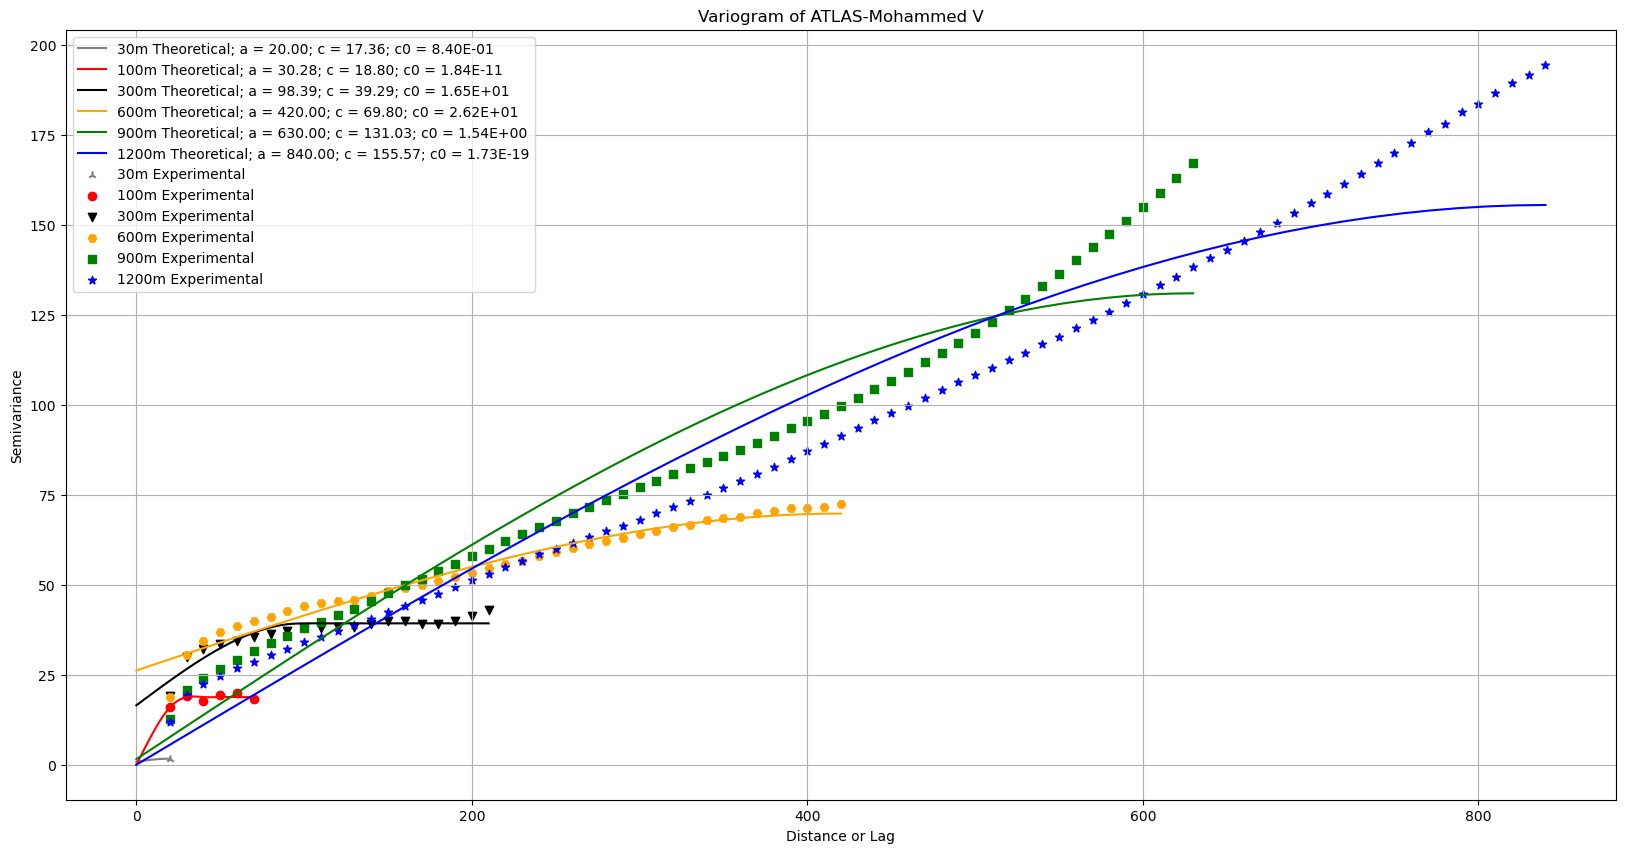

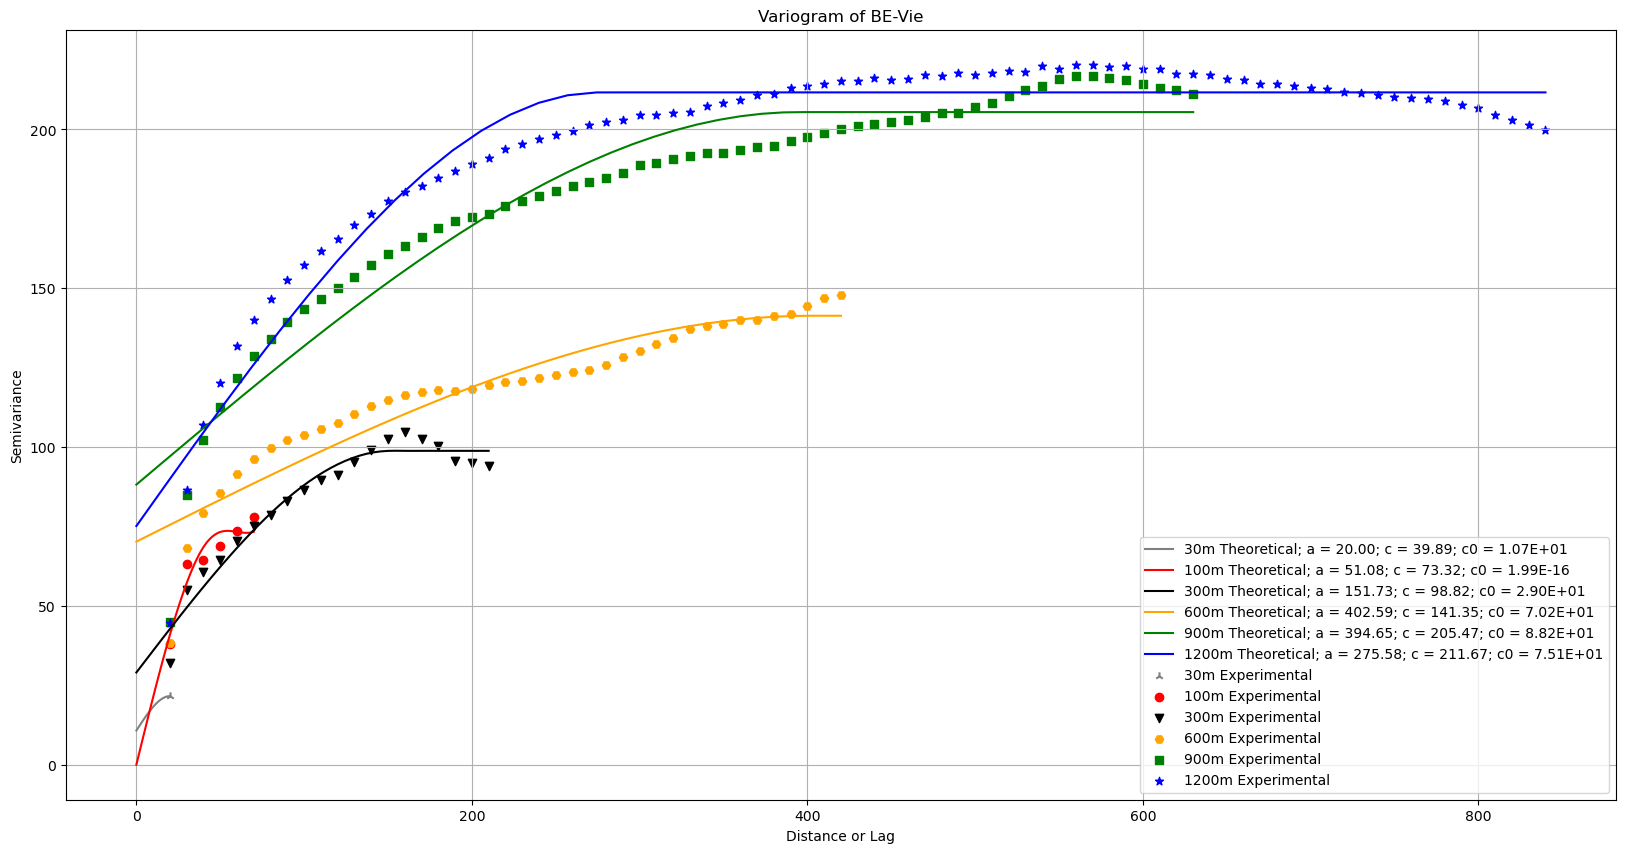

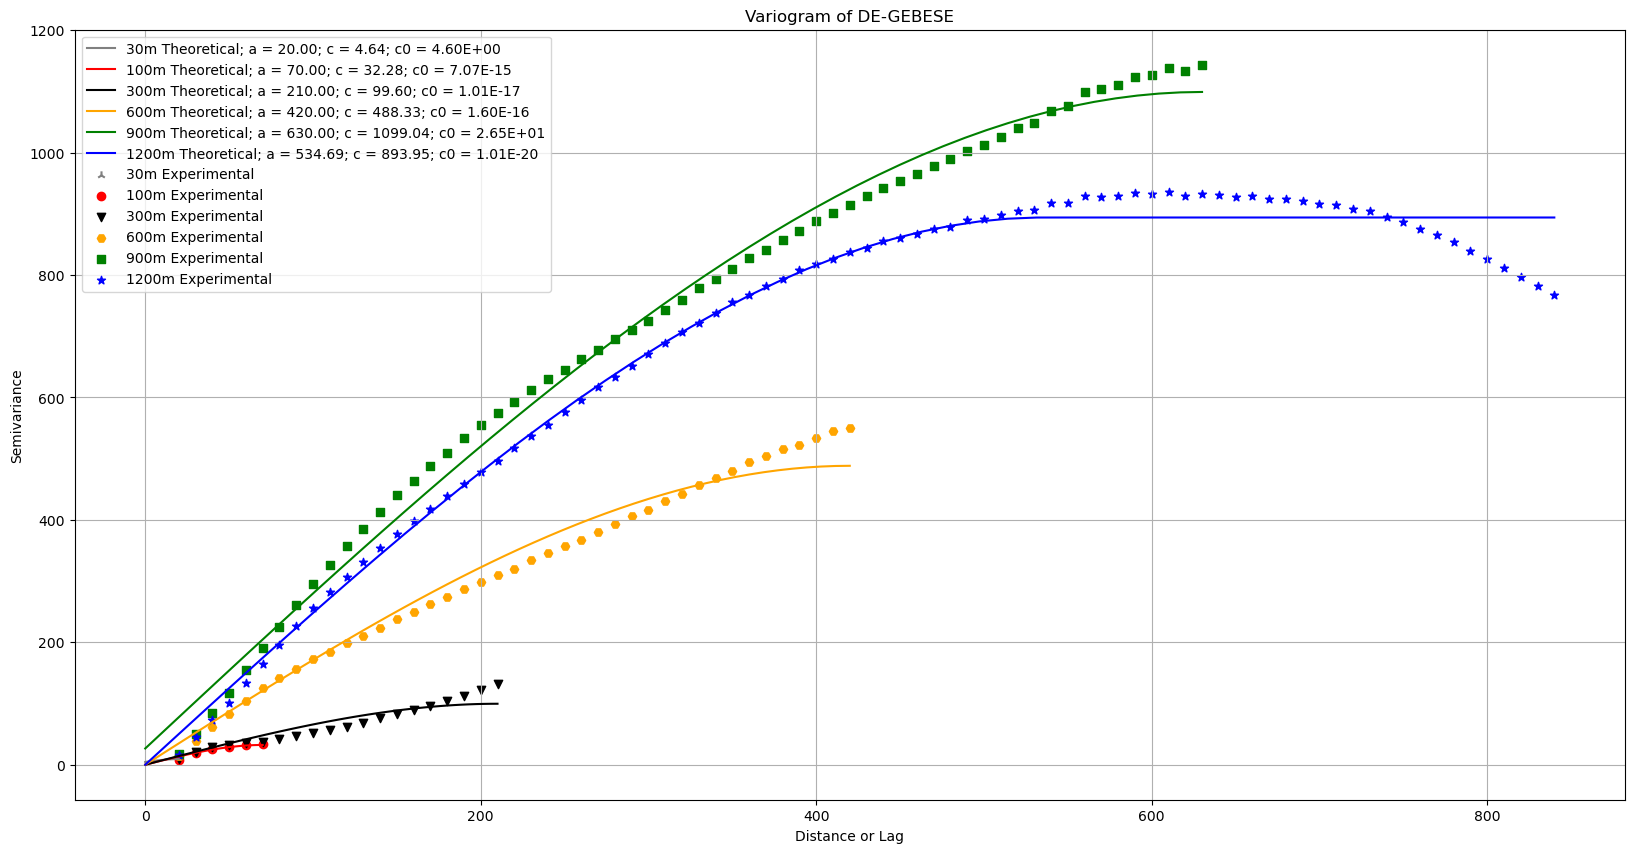

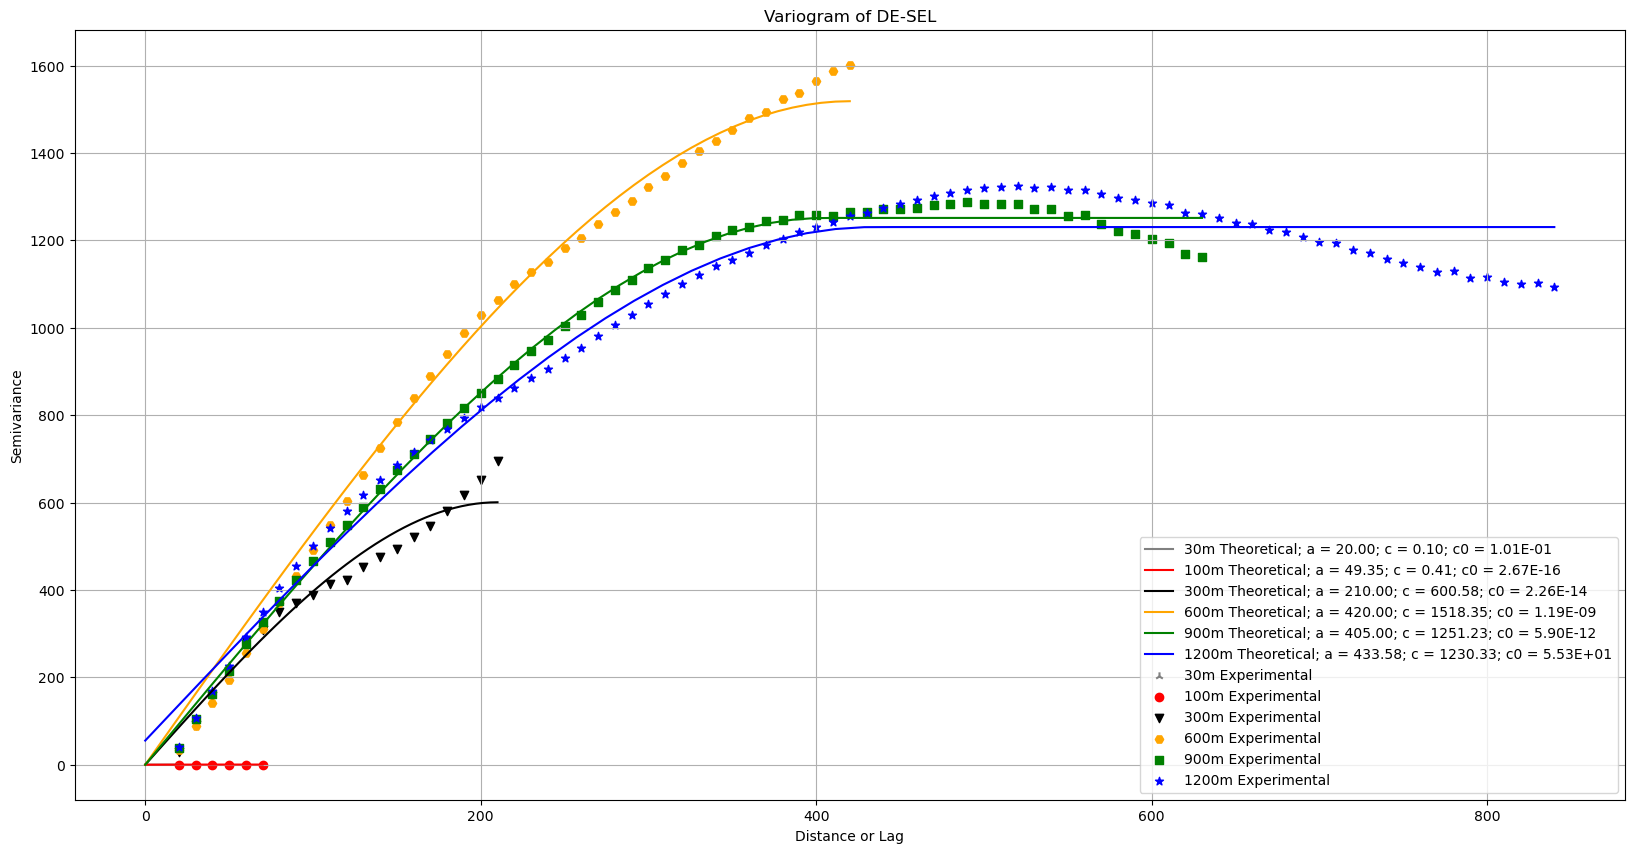

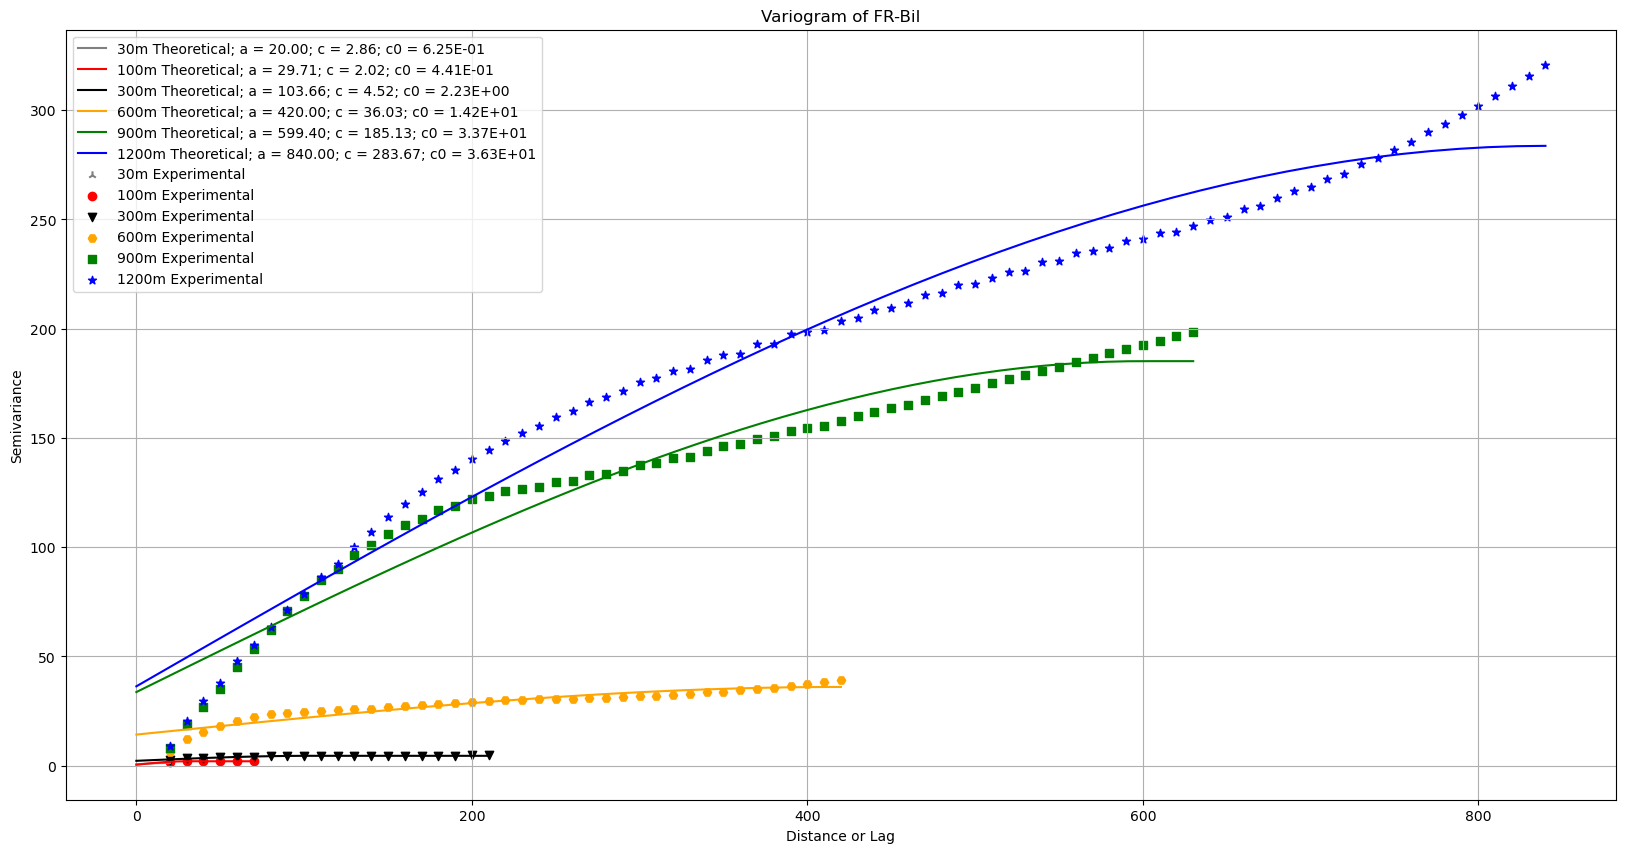

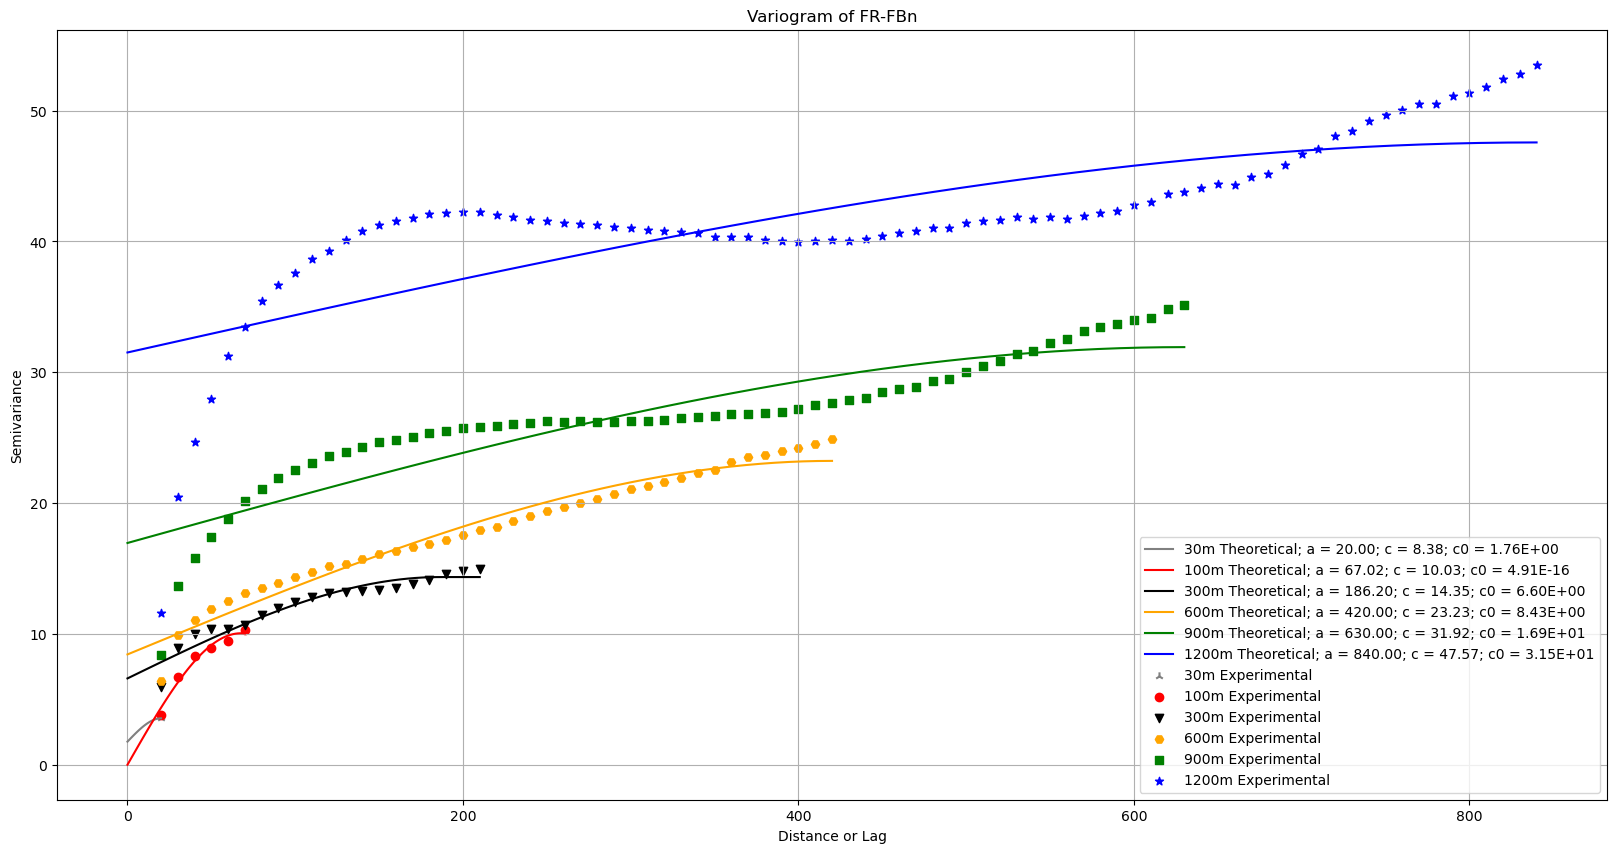

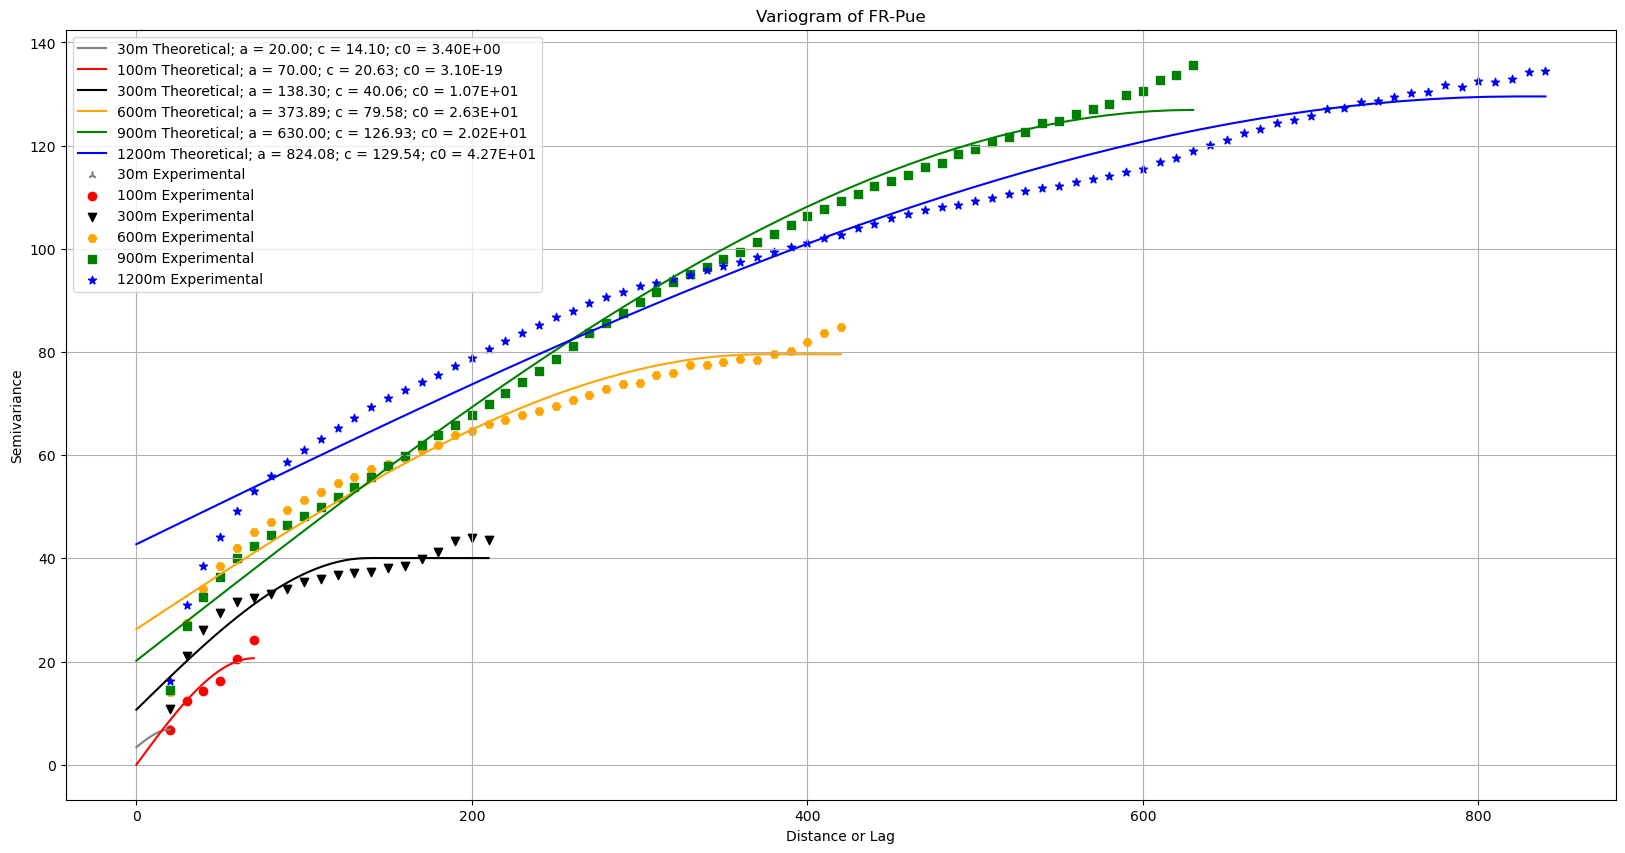

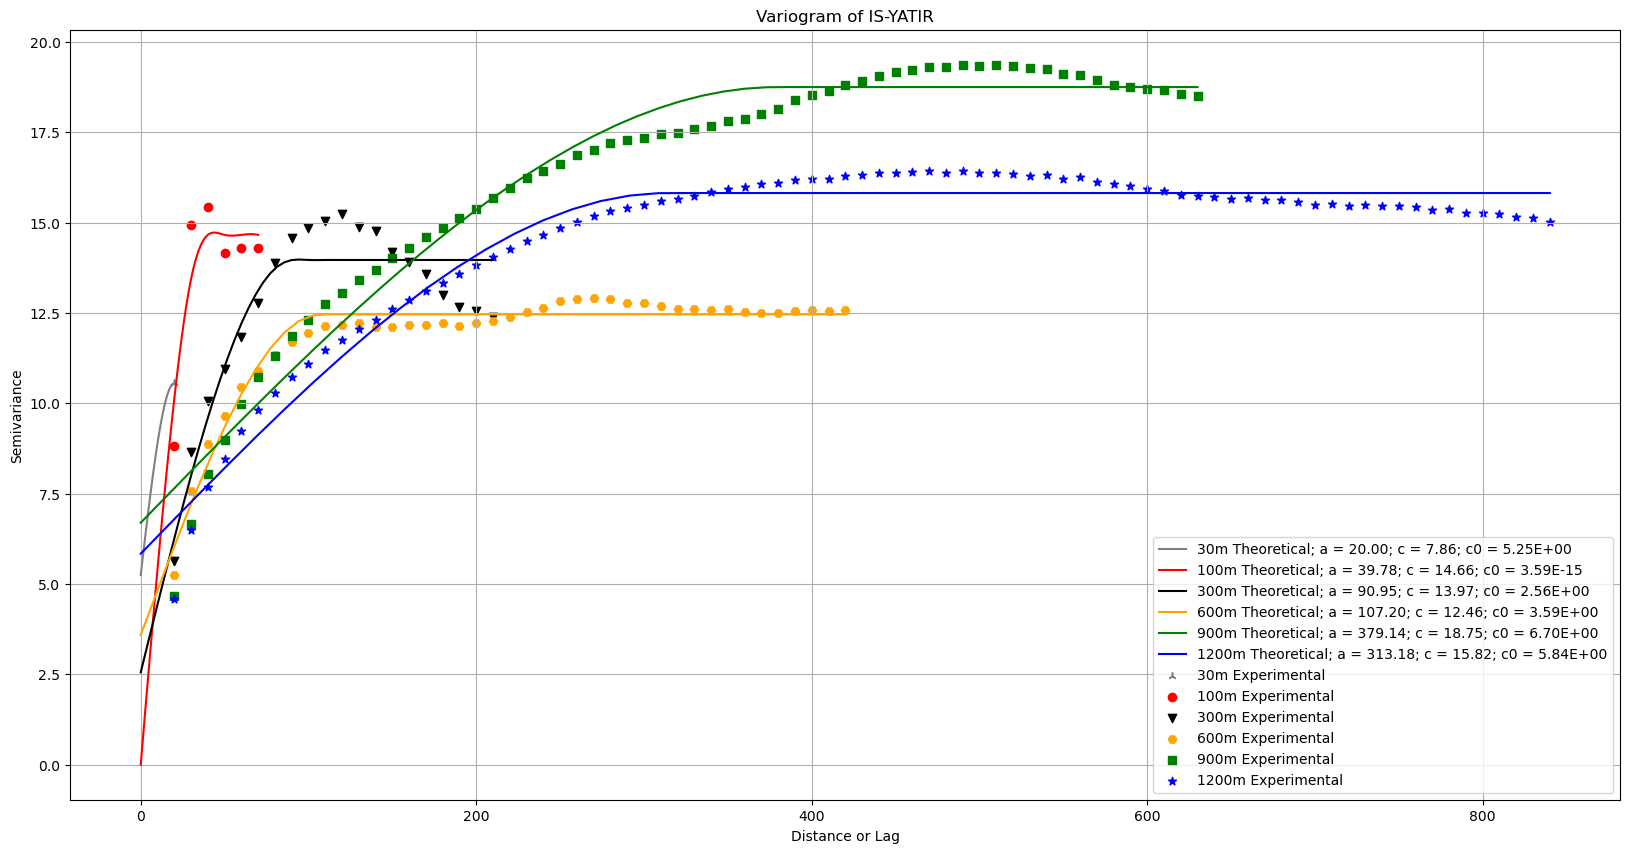

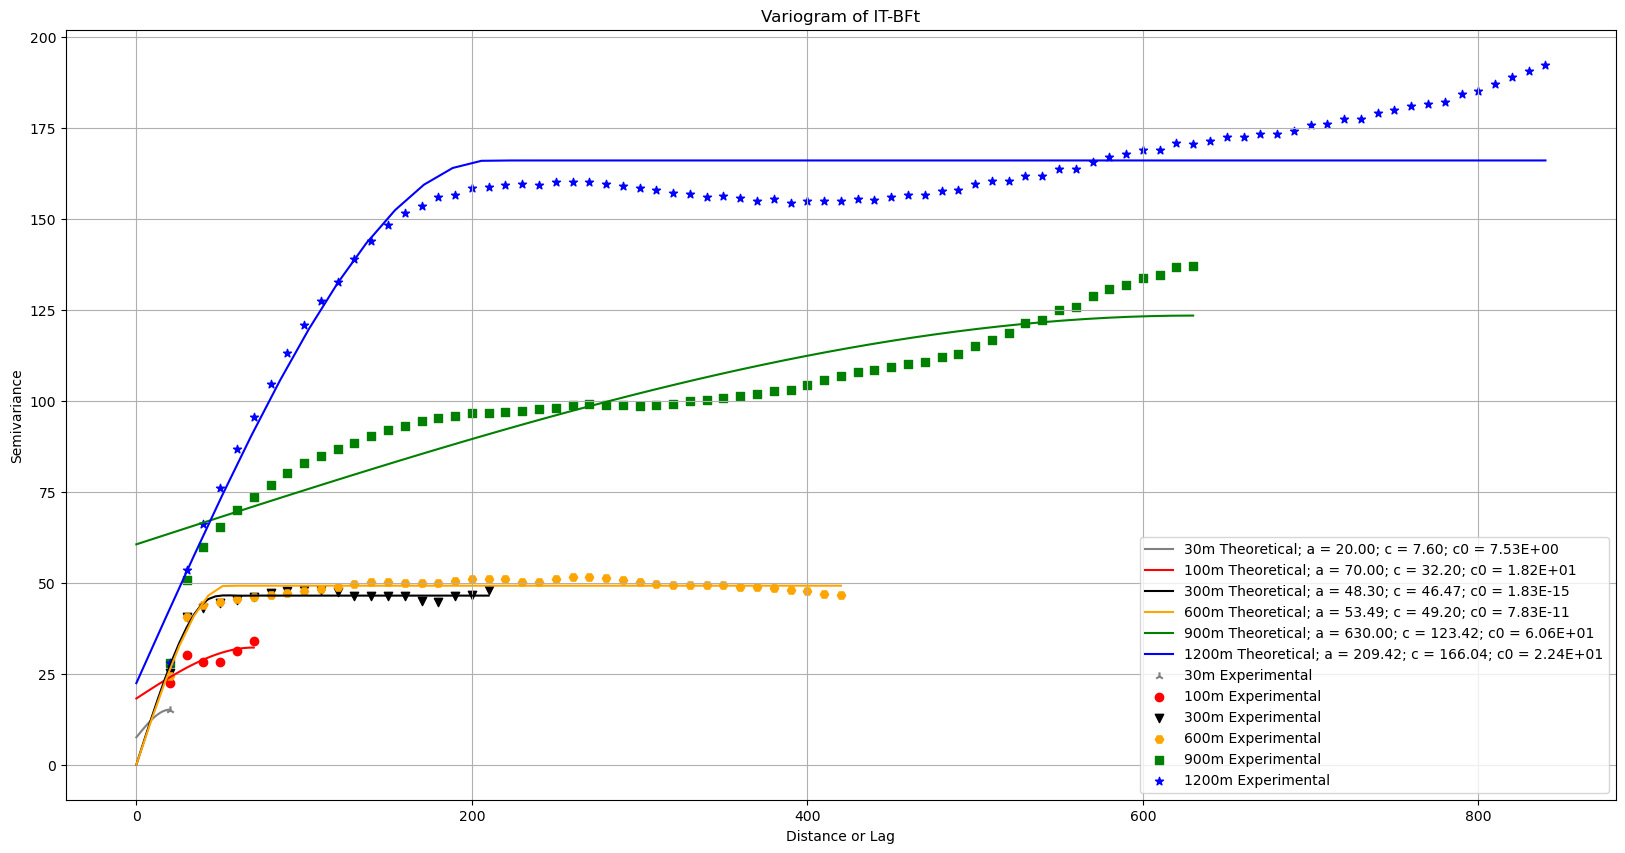

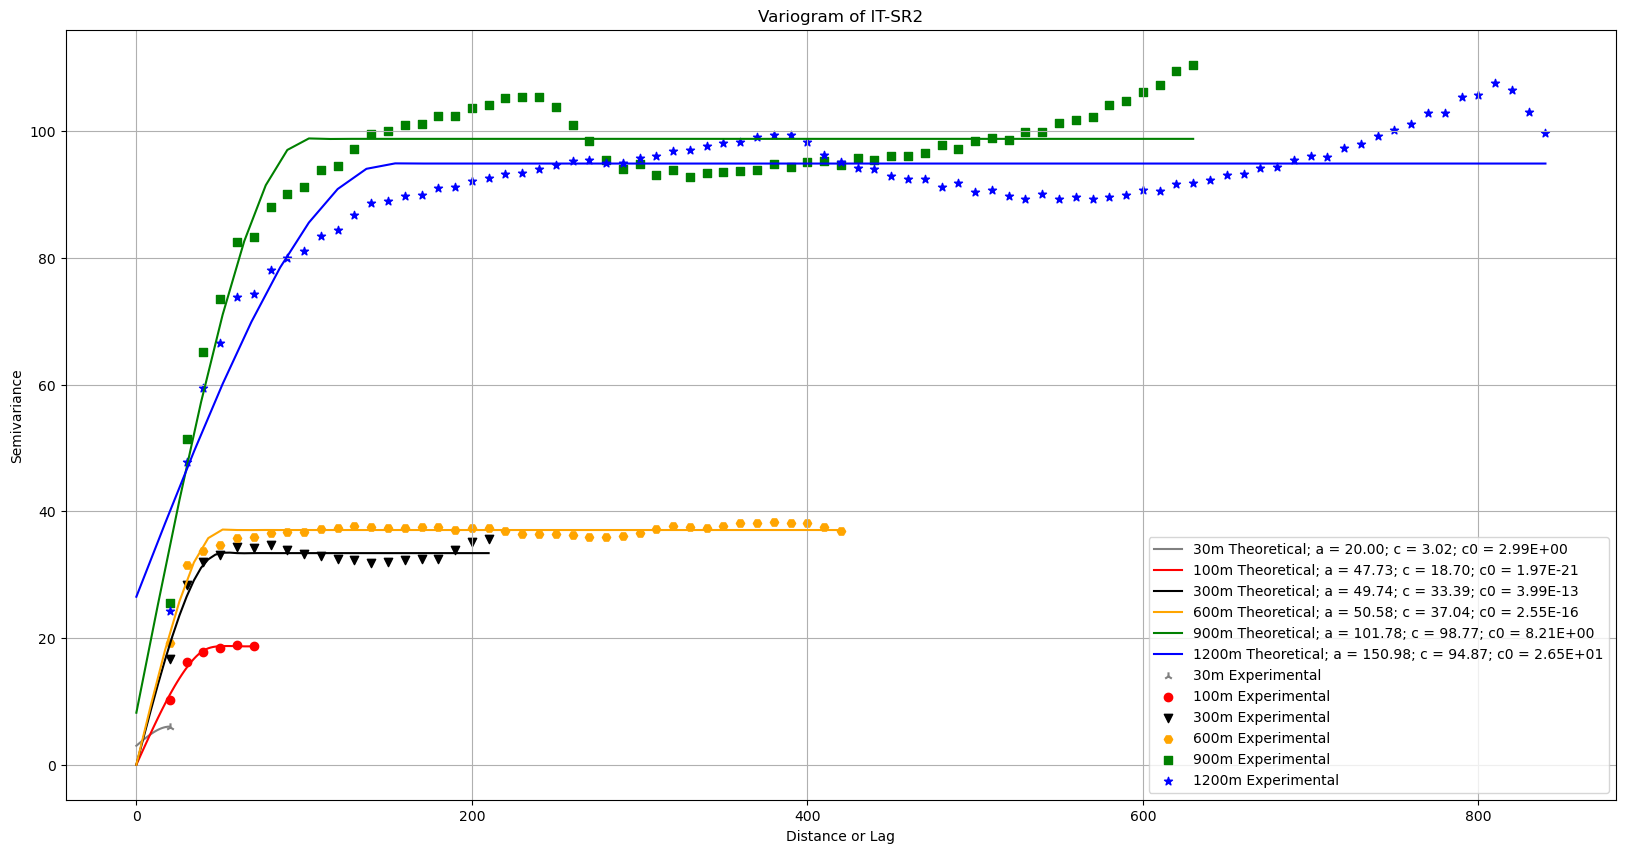

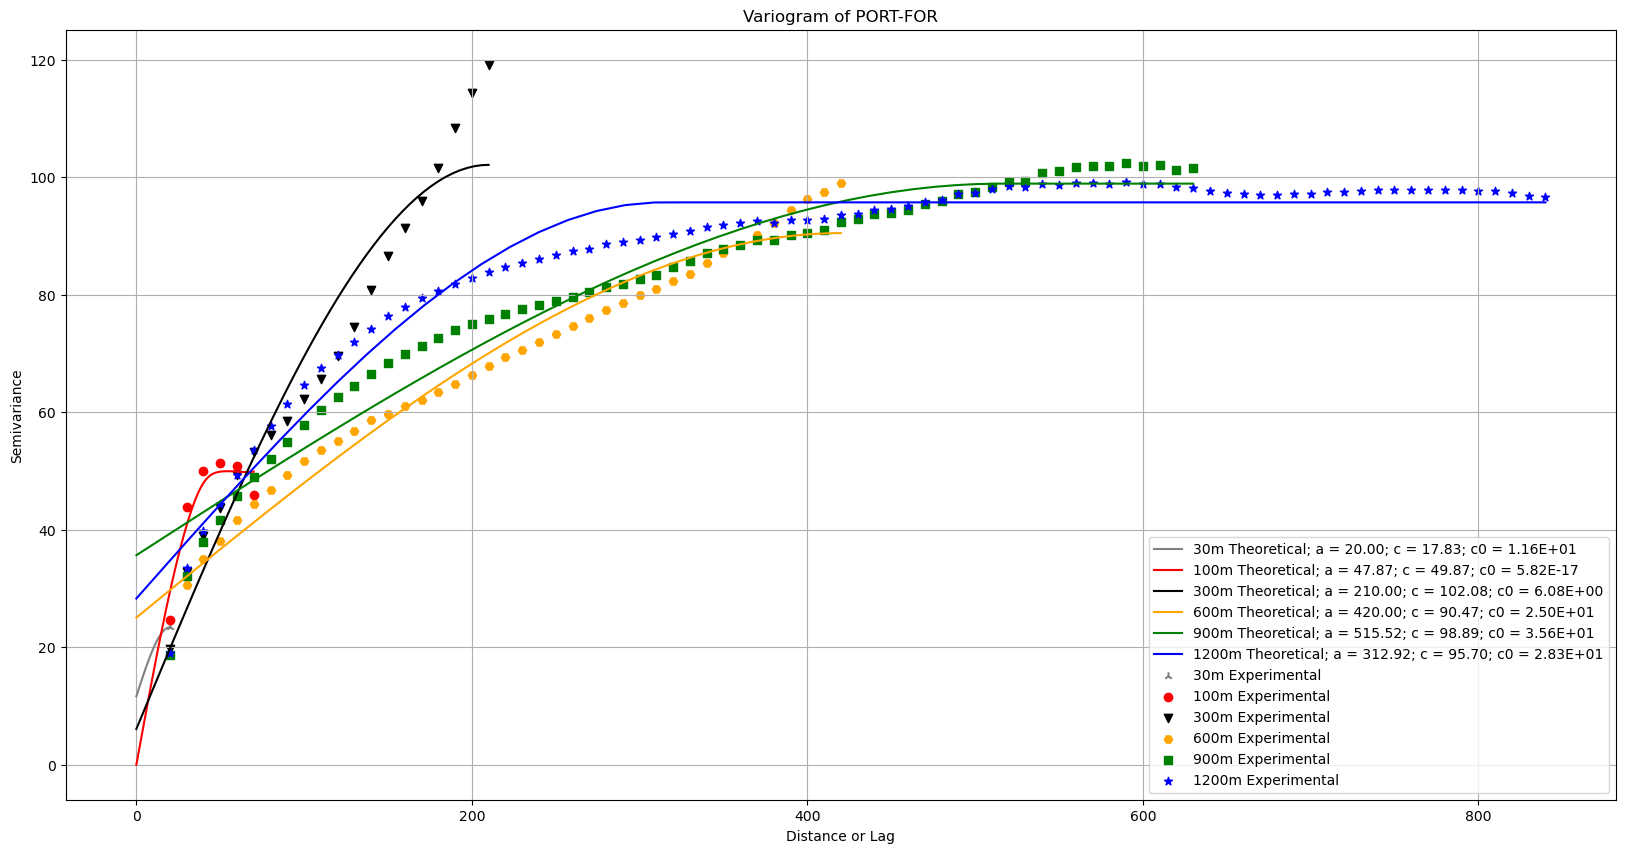

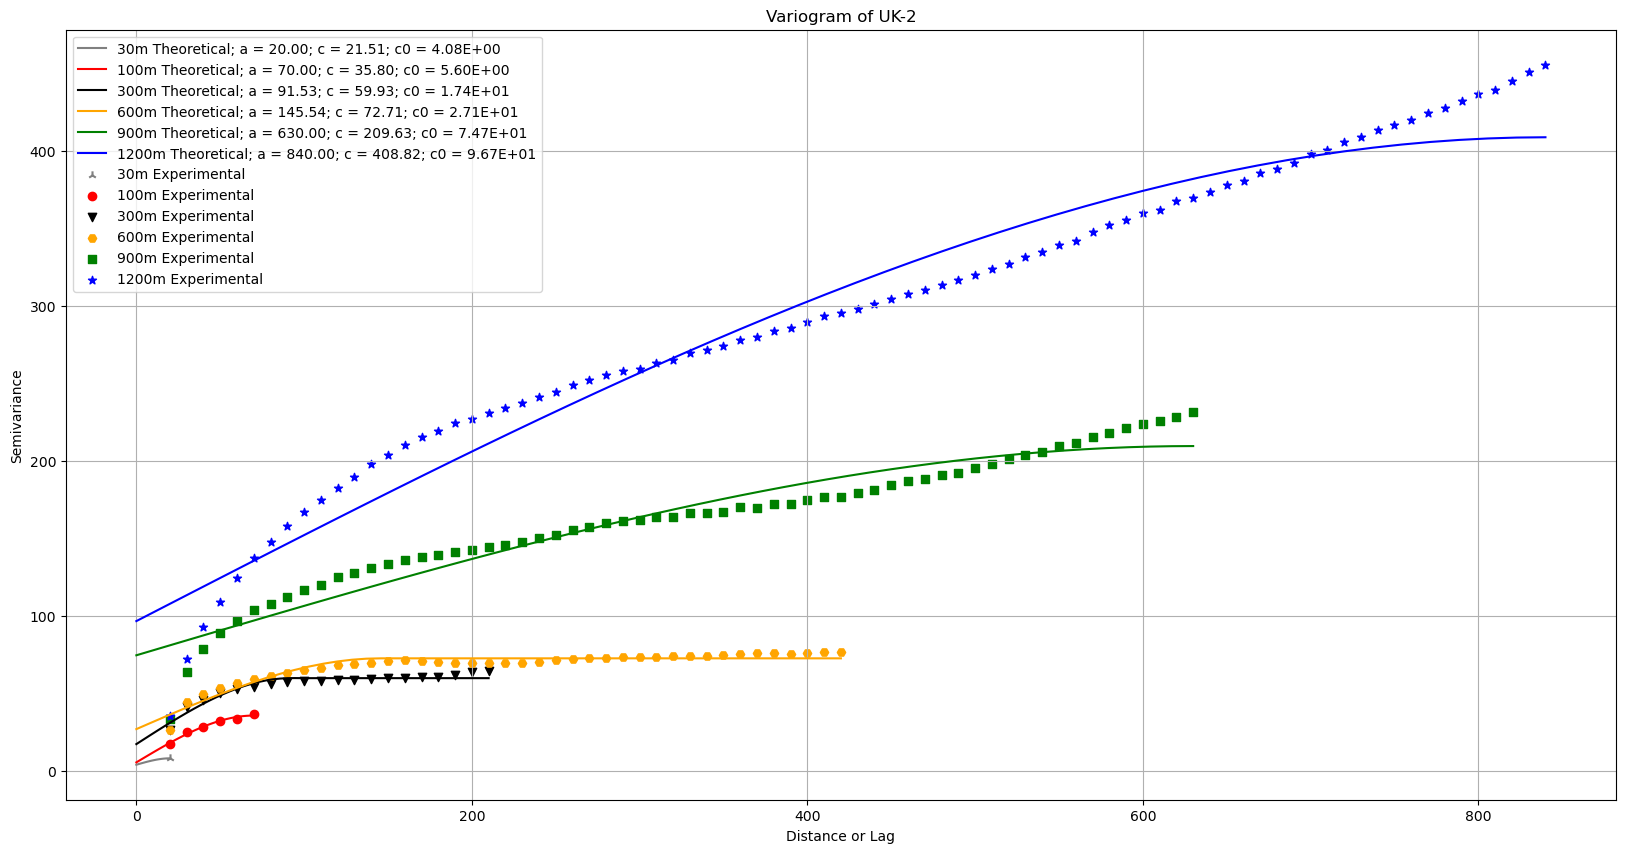

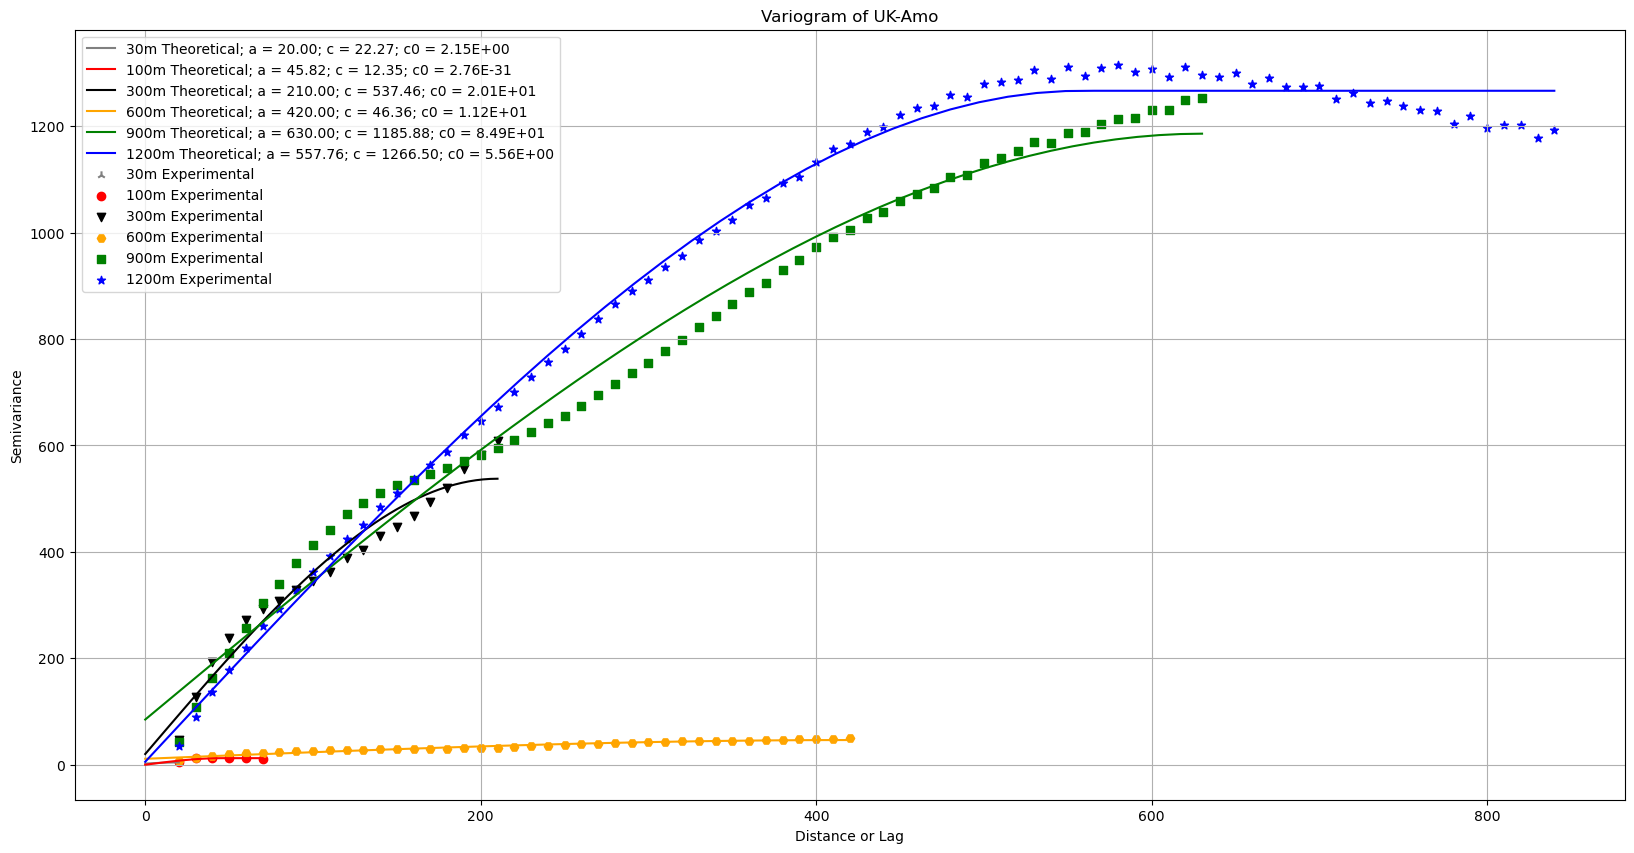

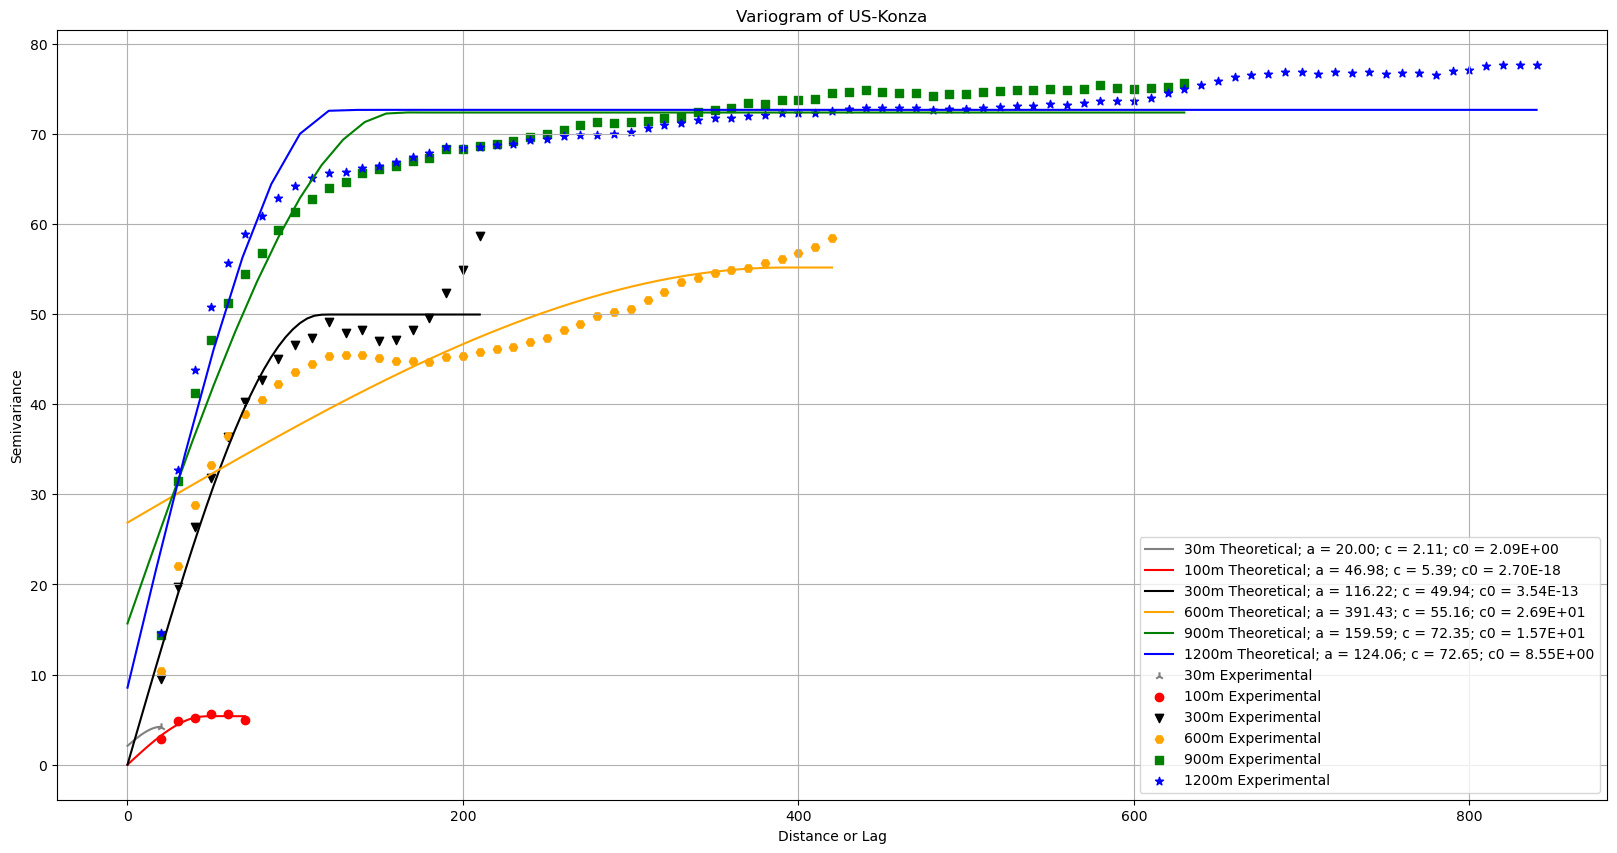

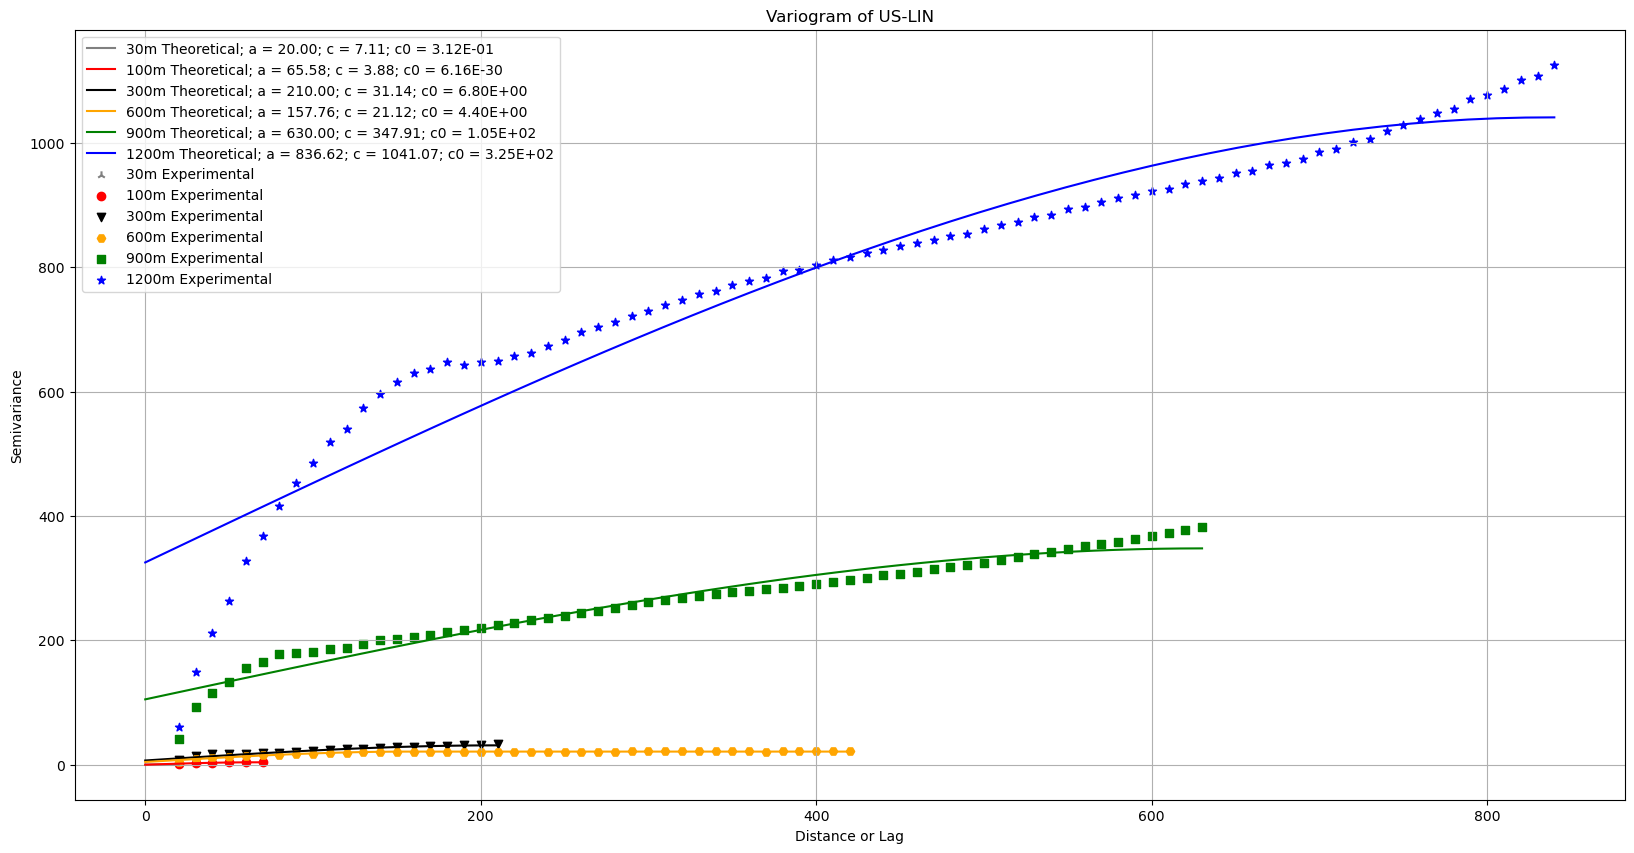

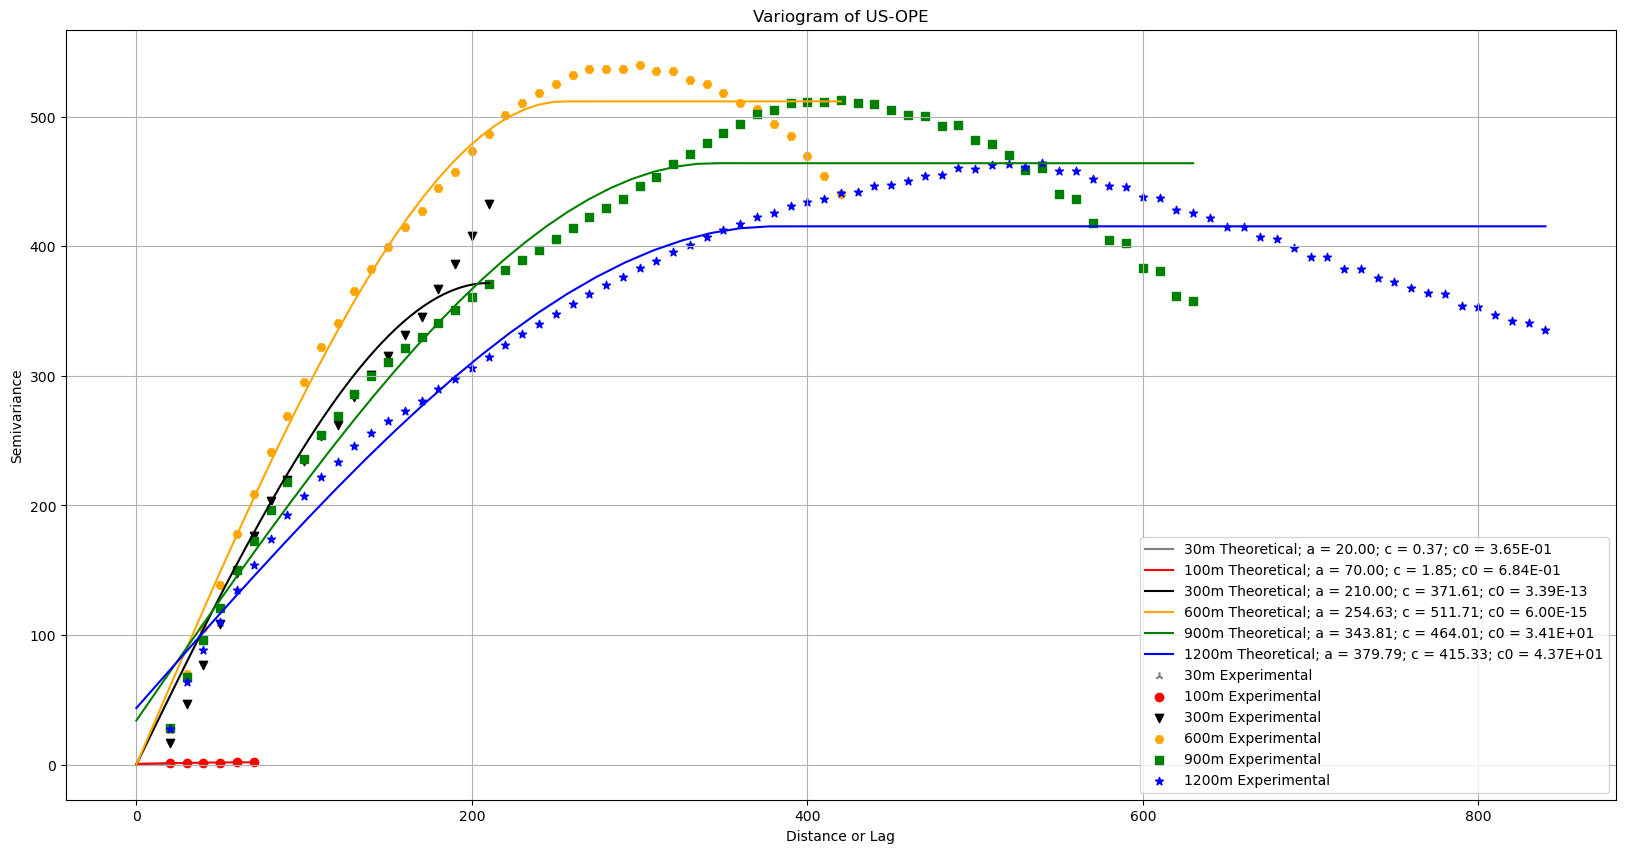

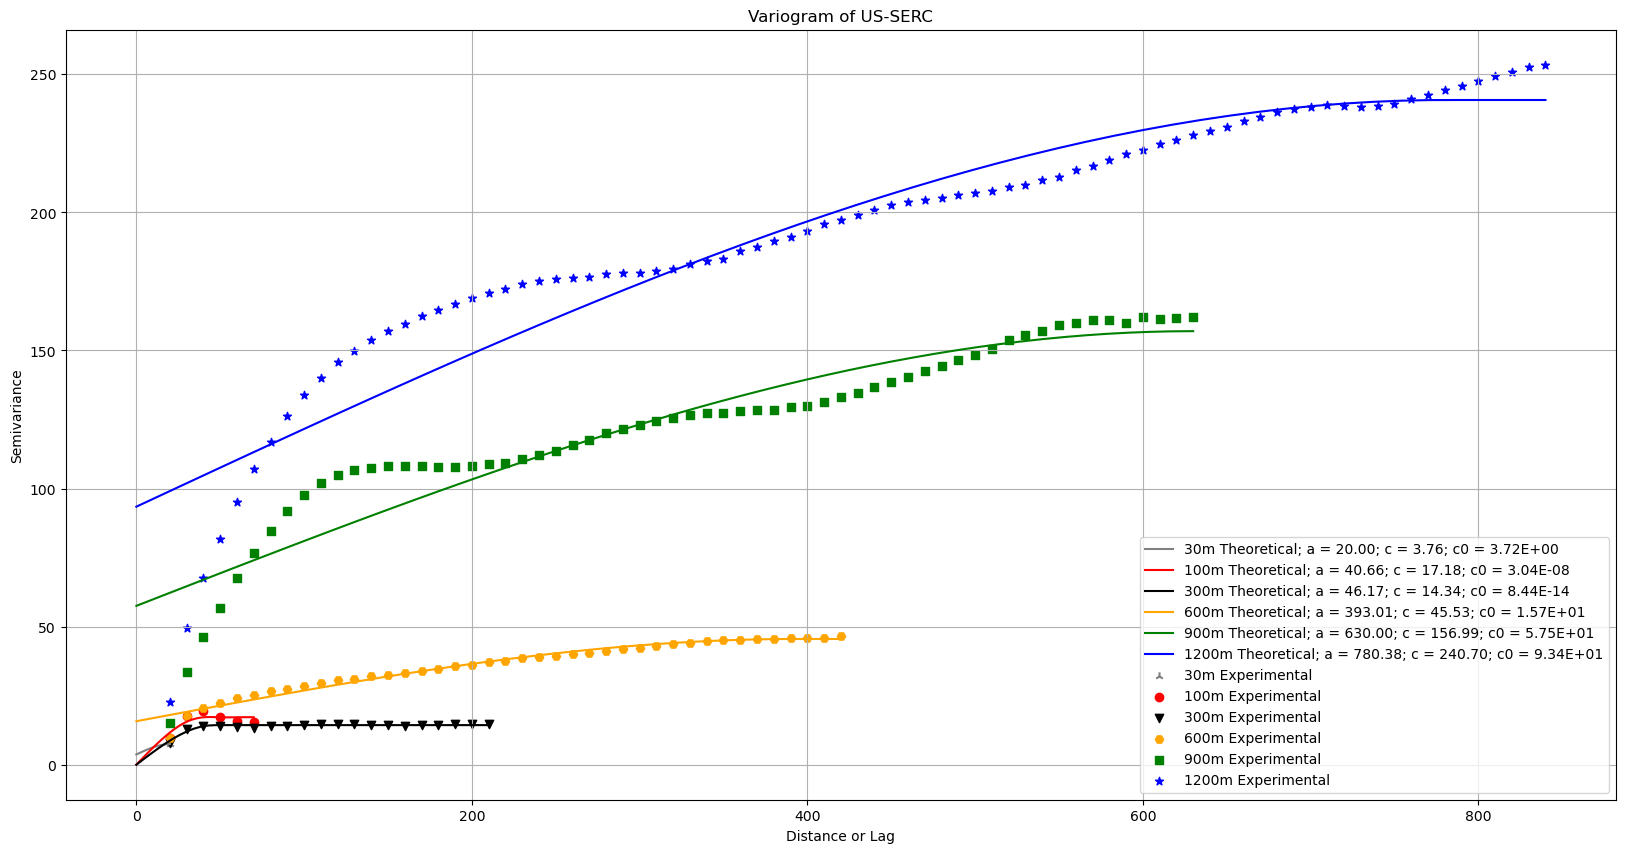

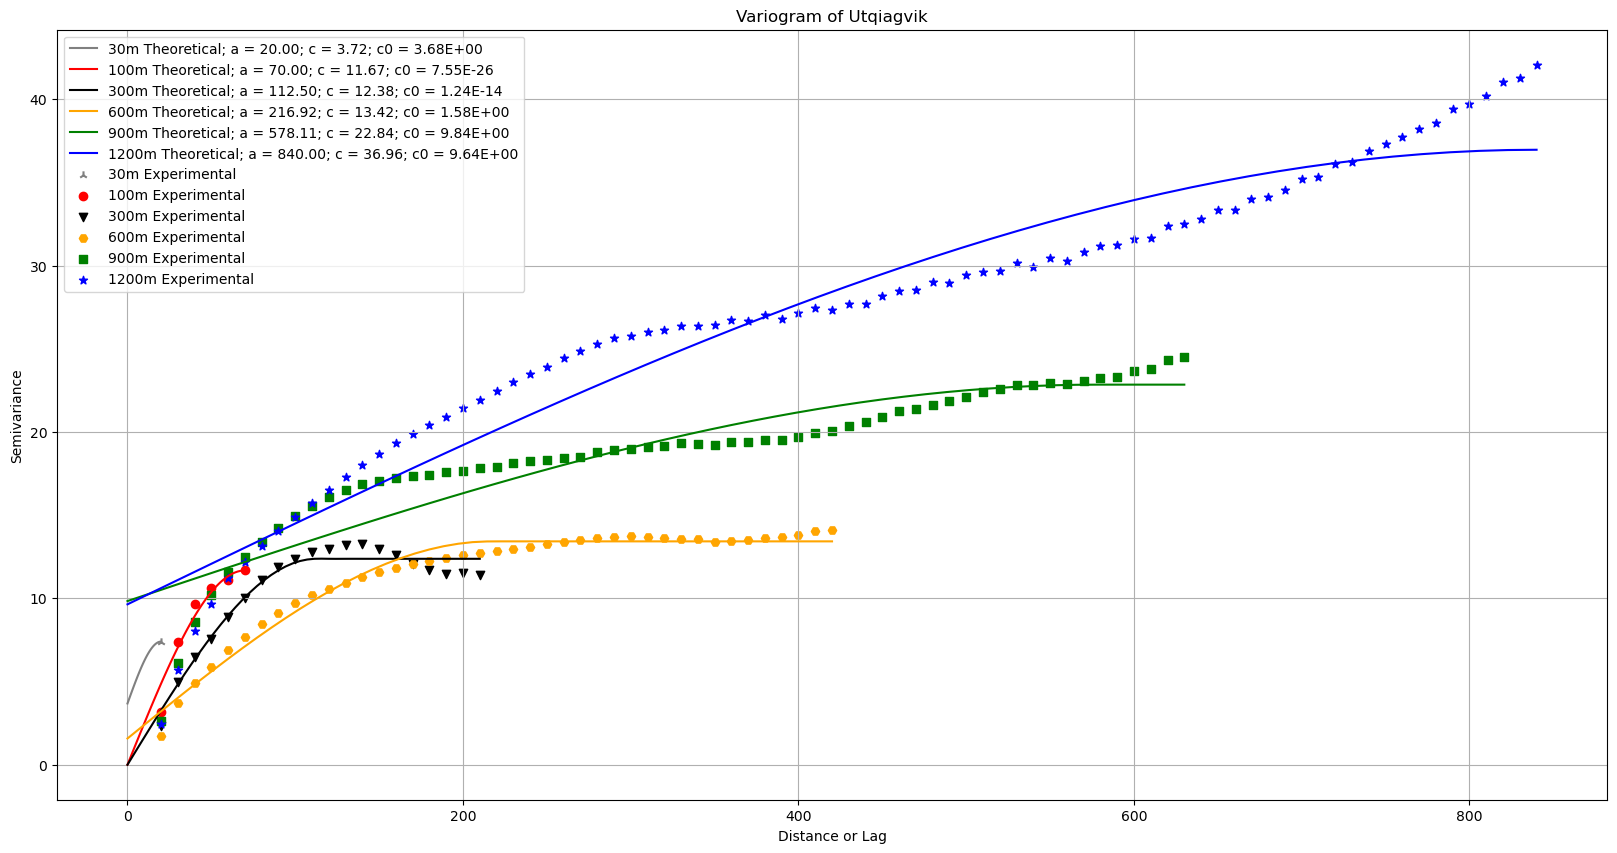

In [19]:
for index in range(len(df_Site)):
    site_Name = df_Site['Site'][index]
    my_Variogram(site_Name)
    print(site_Name + " Done!")